**This notebook demonstrates Sentinel 2 image fusion (MS-MS fusion) using SURE and BP:**
- Data: the HSI APEX (assumed as ground truth) is simulated S2 data as in [1]
    - Simulated LR bands (20 and 60 m) data are generated by apply the PSF filtering and downsampling to the ground truth, and adding Gaussian noise with SNR = 40 dB, and SNR = 30 dB, i.e.,$\mathbf{Y}=\mathbf{HX}+\mathbf{n}$.
    - Simulated 10 m bands are a part of ground truth
- Loss function $$\mathcal{L}_{sure}=\|\mathbf{P}(\mathbf{y}-\mathbf{H}f_\theta(\mathbf{y})\|^2)+2\text{tr}\big[(\Omega_P)\mathbf{PH}\frac{\partial f_\theta(\mathbf{z})}{\partial\mathbf{u}}\big],$$
where $\mathbf{P}$ is a linear operator mapping LR image to its HR space, $\mathbf{z}$ is the network input (concatenating $\mathbf{u}=\mathbf{H^\dagger y}$ and $\mathbf{G}$) and $f_\theta(\cdot)$ is the network output.

In [1]:
# =============================================================================
# import lib
# =============================================================================
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from models.s2_models import *
from utils.s2_utils import *
from utils.common_utils import *
torch.cuda.get_device_name() # cuda was called in some help function above

'NVIDIA GeForce GTX 1080 Ti'

In [2]:
# =============================================================================
# load data
# =============================================================================
d = np.array([6, 1, 1, 1, 2, 2, 2, 1, 2, 6, 2, 2])
mtf = np.array([.32, .26, .28, .24, .38, .34, .34, .26, .33, .26, .22, .23])
path_to_data = 'data/S2/apex_gt.mat'
gt = sio.loadmat(path_to_data)['Xm_im'].astype(np.float32)
scale=np.max(gt)
# GT = gt
GT = gt/scale
SNRdb=40.
x10 = torch.from_numpy(GT[:,:,d==1])
x20 = torch.from_numpy(GT[:,:,d==2])
x60 = torch.from_numpy(GT[:,:,d==6])
X60 = hwc2chw(x60)
X20 = hwc2chw(x20)
X10 = hwc2chw(x10)

psf20 = get_s2psf(size=15,band='band20')
psf60 = get_s2psf(size=15,band='band60')
Y20 = Ax(X20,psf20,2)
Y60 = Ax(X60,psf60,6)

ref20=gt[:,:,d==2]
ref60=gt[:,:,d==6]
ref = np.concatenate((gt[:,:,d==2],gt[:,:,d==6]),axis=2)
cond=1e-4
[y20,sigma20] = add_noise(Y20,SNRdb)
[y60,sigma60] = add_noise(Y60,SNRdb)
[y10,sigma10] = add_noise(X10,SNRdb)
y20ml = back_projx(y20,psf20,2,cond)
y60ml = back_projx(y60,psf60,6,cond)
sigmas=[sigma10,sigma20,sigma60]

60 m bands shape:  torch.Size([2, 33, 33])
20 m bands shape:  torch.Size([6, 99, 99])
10 m bands shape:  torch.Size([4, 198, 198])


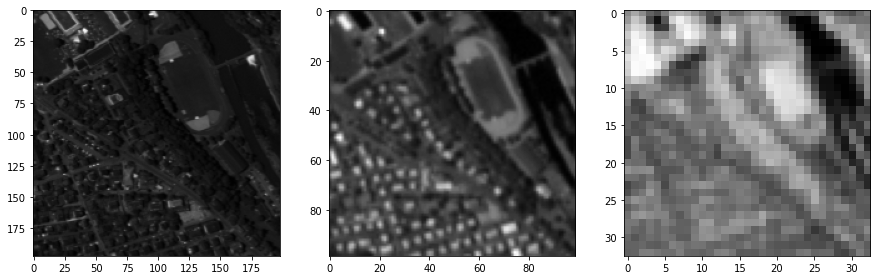

In [3]:
# =============================================================================
# show images
# =============================================================================
print('60 m bands shape: ', y60.shape)
print('20 m bands shape: ', y20.shape)
print('10 m bands shape: ', y10.shape)
thresholdRGB=1
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(y10[1,:,:].cpu(),cmap='gray')
ax2.imshow(y20[5,:,:].cpu(),cmap='gray')
ax3.imshow(y60[1,:,:].cpu(),cmap='gray')
plt.show()

In [4]:
net_input = torch.cat((y10,y20ml,y60ml),dim=0)[None,:]
# inputs=torch.randn(net_input.shape).to(device)
y=[y10,y20,y60]

In [5]:
def s2_sure_loss(z,y,net,sigmas,psfs,cond,loss_type="sure"):
    '''BP, and BP-SURE losses
    z: input (1,c,m,n); y:observation (target); net: network; sigmas: sigmas for 10, 20 and 60 bands
    psfs: psfs for 10, 20, and 60 m bands; cond=1e-3; loss_type: "sure" or "bp"'''
    psf20=psfs[0]
    psf60=psfs[1]
    sigma10=sigmas[0]**2
    sigma20=sigmas[1]**2
    sigma60=sigmas[2]**2
    y10=y[0]
    y20=y[1]
    y60=y[2]
    xhat = net(z)
    hxhat20 = Ax(xhat.squeeze()[4:10,:,:],psf20,2) - y20
    hxhat60 = Ax(xhat.squeeze()[10:,:,:], psf60, 6) - y60
    pxhat10 = xhat.squeeze()[:4,:,:] - y10
    pxhat20 = back_projx(hxhat20,psf20,2,cond)
    pxhat60 = back_projx(hxhat60, psf60, 6, cond)
    
    loss_bp = torch.sum(pxhat10**2)+torch.sum(pxhat20**2)+torch.sum(pxhat60**2)
    # Compute divergence term by Monte-Carlo SURE
    ep = 1e-5
    b=torch.randn(z.shape).to(device)
    oute = (net(z+ep*b)-xhat)/ep
    houte20=Ax(oute.squeeze()[4:10,:,:],psf20,2)
    houte60=Ax(oute.squeeze()[10:,:,:],psf60,6)
    tmp20=invAAtx(houte20,psf20,2,cond)*sigma20
    tmp60=invAAtx(houte60,psf60,6,cond)*sigma60
    outep20 = back_projx(tmp20,psf20,2,cond)
    outep60 = back_projx(tmp60, psf60, 6, cond)
    outep10 = oute.squeeze()[:4,:,:]*sigma10

    div = torch.sum(b.squeeze()[:4,:,:]*outep10) + torch.sum(b.squeeze()[4:10,:,:]*outep20) +torch.sum(b.squeeze()[10:,:,:]*outep60)
    if loss_type == "bp":
        return loss_bp,xhat
    elif loss_type=="sure":
        return loss_bp+2*div,xhat
    else:
        print("none of loss used")


In [6]:
# =============================================================================
# Set parameters and net
# =============================================================================
show_every = 200
num_iter = 3100
LR = 0.01
thresholdRGB=1.
showband10=[0,1,2]
showband20=[9,7,4]
showband60=[10,11,10]
net=s2_attention_net().type(dtype)
psfs=[psf20,psf60]

Starting optimization with ADAM with sure loss
Iteration 00000   MSRE -4.703


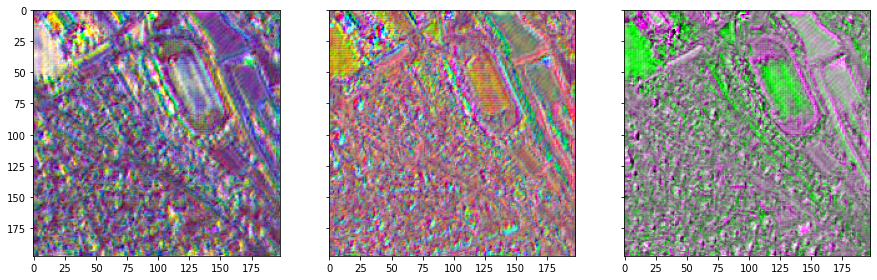

Iteration 00200   MSRE 20.316


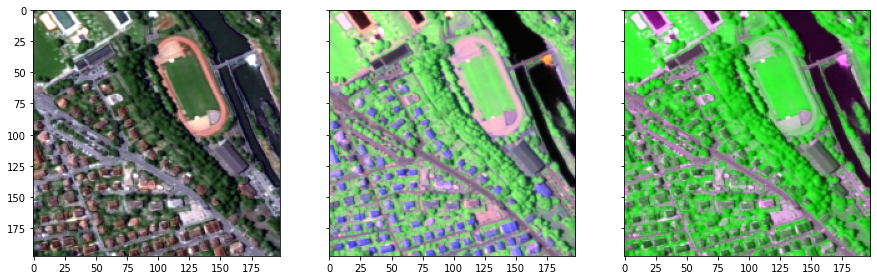

Iteration 00400   MSRE 22.955


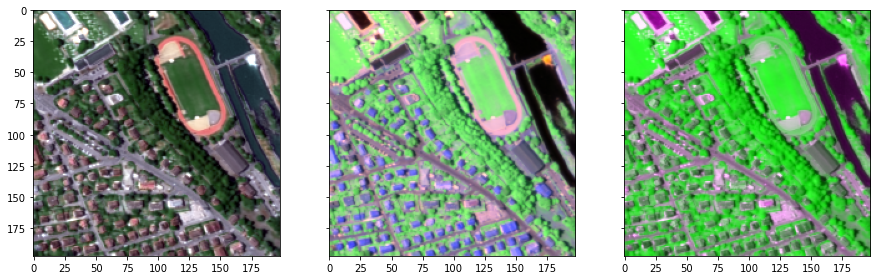

Iteration 00600   MSRE 23.929


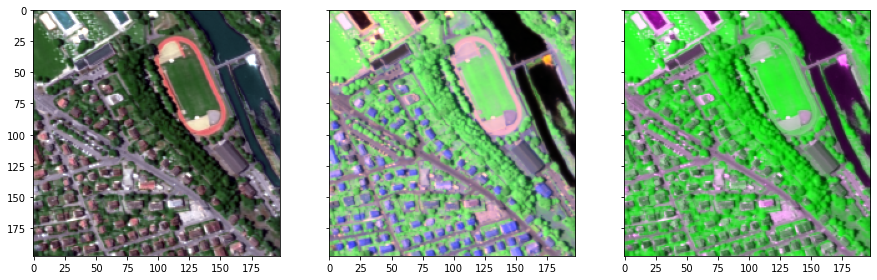

Iteration 00800   MSRE 25.064


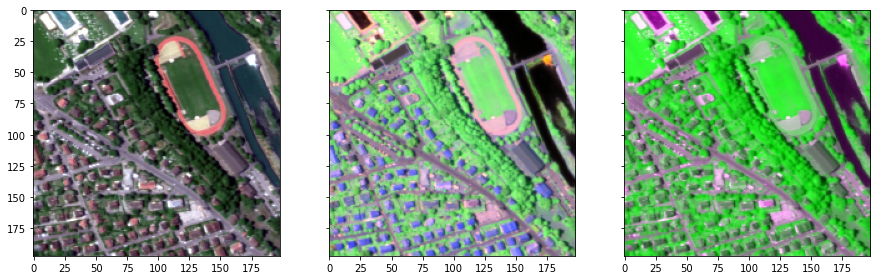

Iteration 01000   MSRE 25.352


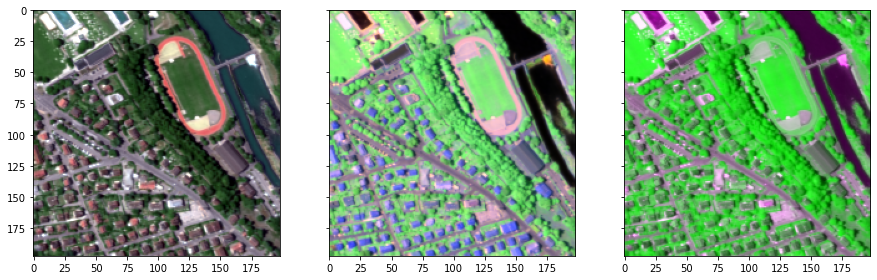

Iteration 01200   MSRE 25.966


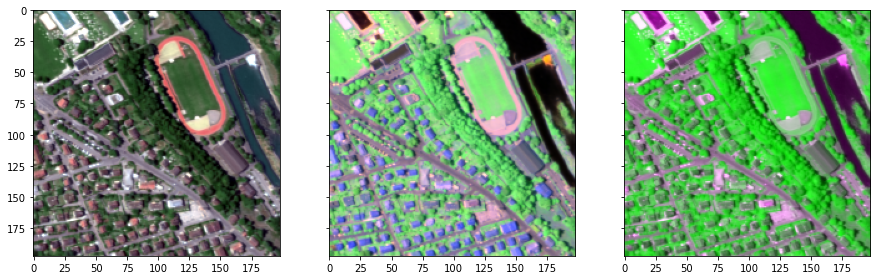

Iteration 01400   MSRE 26.259


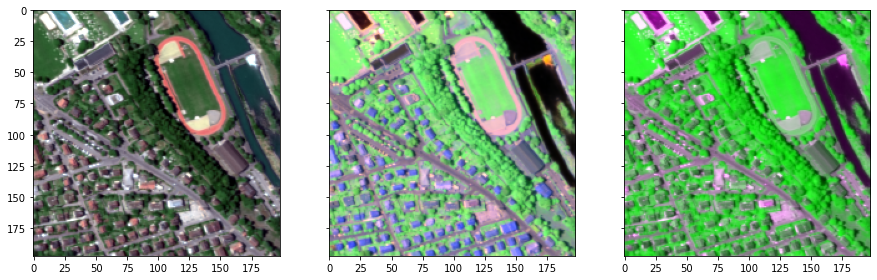

Iteration 01600   MSRE 26.278


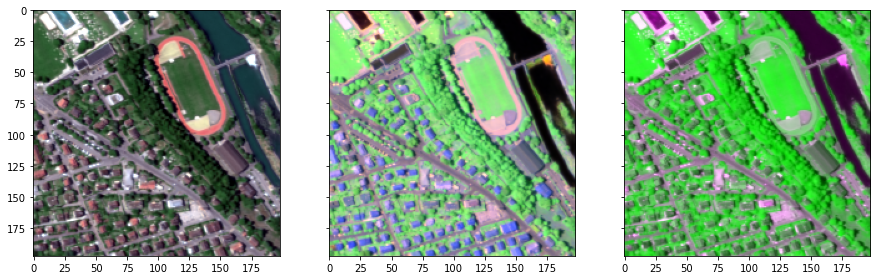

Iteration 01800   MSRE 26.766


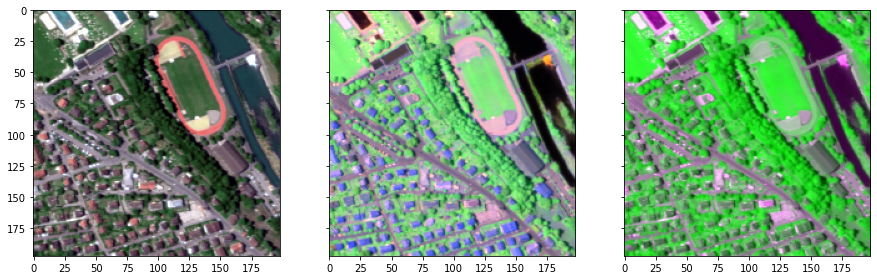

Iteration 02000   MSRE 26.648


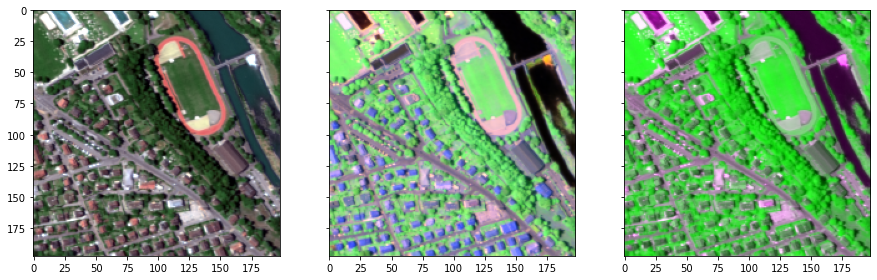

Iteration 02200   MSRE 27.068


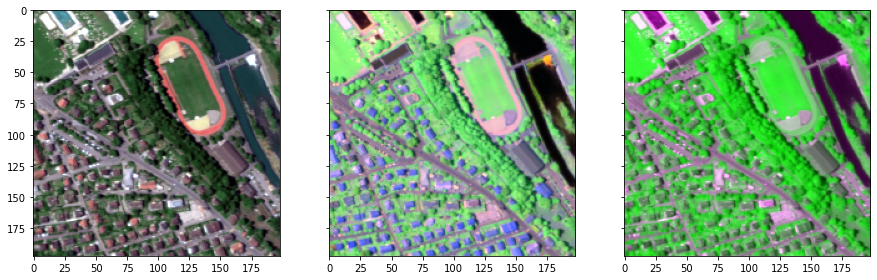

Iteration 02400   MSRE 27.152


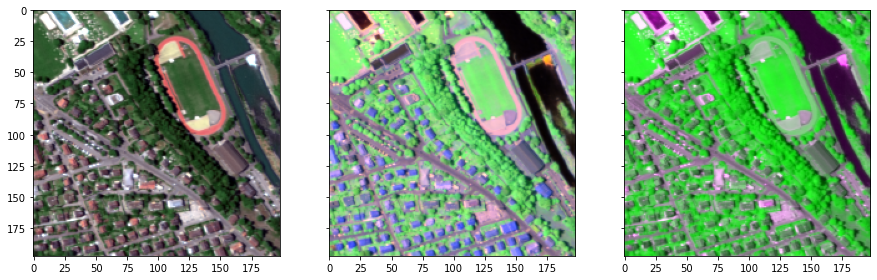

Iteration 02600   MSRE 27.295


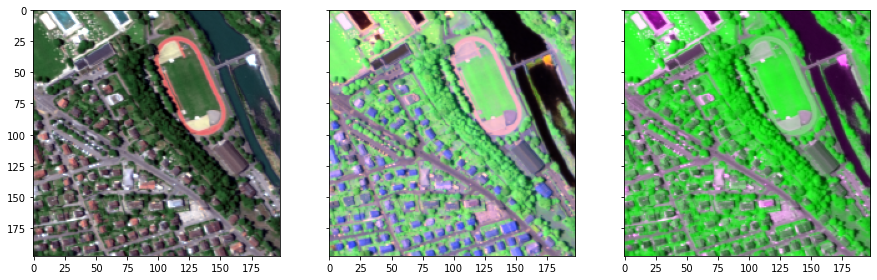

Iteration 02800   MSRE 27.383


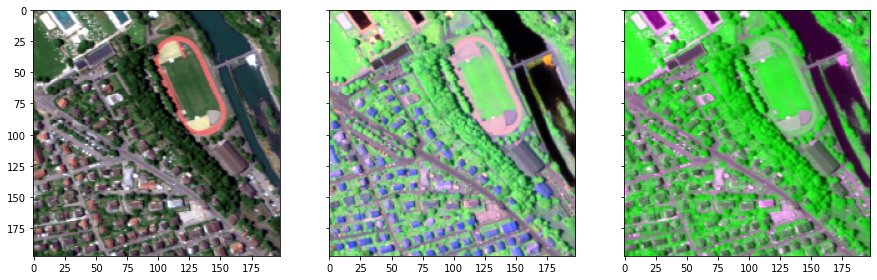

Iteration 03000   MSRE 27.345


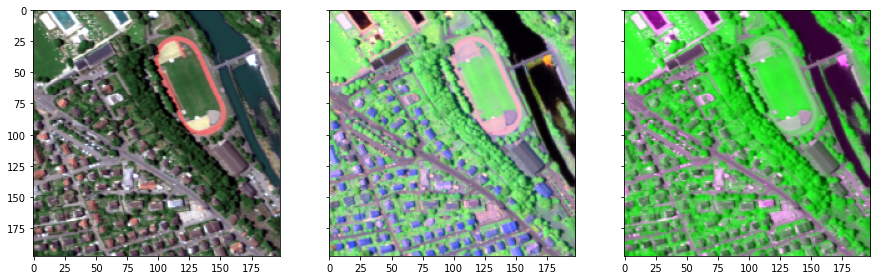

In [7]:
# =============================================================================
# Optimization
# =============================================================================
# total_loss=[]
sre=[]
sre20=[]
sre60=[]
out_avg=None
exp_weight=0.99
loss_type="sure"
p = net.parameters()
print('Starting optimization with ADAM with '+loss_type+" loss")
optimizer = torch.optim.Adam(p, lr=LR,amsgrad=True)

for it in range(num_iter):
    optimizer.zero_grad()
    loss,xhat = s2_sure_loss(net_input,y,net,sigmas,psfs,cond,loss_type=loss_type)
    out_np = chw2hwc(xhat.detach().cpu().squeeze()).numpy()
    sre.append(sreCal(ref,out_np[:,:,4:]*scale))
    
#     if out_avg is None:
#             out_avg = out_np
#     else:
#         out_avg = out_avg * exp_weight + out_np * (1 - exp_weight)
#     if it==3000:
#         sio.savemat("apex_out"+loss_type+"40"+".mat",mdict={"img_"+loss_type:out_avg})

    loss.backward()
    optimizer.step()
    if it % show_every == 0:
        print('Iteration %05d   MSRE %.3f' % (it,sreCal(ref,out_np[:,:,4:]*scale)))
        out=out_np*scale
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(sentinel2RGB(out[:,:,showband10],thresholdRGB))
        ax2.imshow(sentinel2RGB(out[:,:,showband20],thresholdRGB))
        ax3.imshow(sentinel2RGB(out[:,:,showband60],thresholdRGB))
        plt.show()

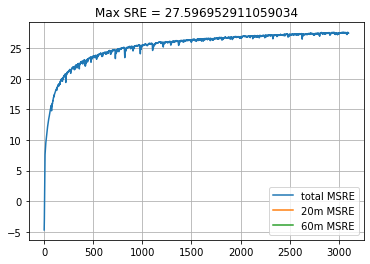

In [8]:
sre_history=np.array(sre)
sre20=np.array(sre20)
sre60=np.array(sre60)
a=np.max(sre_history)
plt.plot(sre_history,label='total MSRE')
plt.plot(sre20,label='20m MSRE')
plt.plot(sre60,label='60m MSRE')
plt.title('Max SRE = '+str(a))
plt.legend()
plt.grid()
plt.show()